# Heart Disease Prediction

This notebook aims to predict heart disease using various machine learning techniques. The dataset includes several medical attributes that contribute to heart disease outcomes. We will perform data preprocessing, explore the creation of interaction terms, encode categorical variables, and apply machine learning models to predict the presence of heart disease.


### Import Libraries

In [ ]:
!pip install sweetviz
!pip install --upgrade setuptools

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import category_encoders as ce
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sweetviz as sv

### Data Loading and Preliminary Exploration

We start by loading the training and test datasets and conduct a brief exploration to understand the structure and type of data we are dealing with.

In [22]:
# Load the data
train_data = pd.read_csv('train_heart.csv', sep=',')
test_data = pd.read_csv('test_heart.csv', sep=',')

# Display the first few rows of the training data
train_data.head()

,id,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,563,55,M,ASY,135,204,1,ST,126,Y,1.1,Flat,1
1,884,67,M,ASY,160,286,0,LVH,108,Y,1.5,Flat,1
2,352,56,M,ASY,120,0,0,ST,100,Y,-1.0,Down,1
3,694,56,M,ATA,120,236,0,Normal,178,N,0.8,Up,0
4,491,75,M,ASY,170,203,1,ST,108,N,0.0,Flat,1


In [10]:
report = sv.analyze(train_data)

report.show_html('heart_analysis.html')

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report heart_analysis.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### Data Preprocessing

In this section, we address missing values, create interaction terms, encode categorical variables, and scale the features to prepare our data for modeling.

First, we address potential outliers and missing values in the dataset. Specifically, we focus on two important variables: `Cholesterol` and `RestingBP` (Resting Blood Pressure). Zero values in these variables are not plausible and likely indicate missing or incorrectly recorded data. We replace these zero values with the median value of the respective variable, which is a robust measure of central tendency that is less sensitive to outliers.

In [23]:
# Filter values for Cholesterol and RestingBP
chol_median = train_data.loc[train_data['Cholesterol'] != 0, 'Cholesterol'].median()
train_data['Cholesterol'].replace(0, chol_median, inplace=True)

resting_median = train_data.loc[train_data['RestingBP'] != 0, 'RestingBP'].median()
train_data['RestingBP'].replace(0, resting_median, inplace=True)

#### Create Interaction Term

Interaction terms can capture the effect of two or more variables acting together on the target variable. Here, we create an interaction term between `Age` and `Cholesterol`, hypothesizing that the combination of these variables might have a different effect on heart disease risk compared to considering them individually.

In [26]:
train_data['Age_Chol_Interact'] = train_data['Age'] * train_data['Cholesterol']

#### Encode Categorical Variables

Many machine learning models cannot handle categorical variables unless they are converted into numerical values. We use ordinal encoding to transform these variables into a numerical format while preserving the order of categories when applicable.

In [27]:
categorical_columns = train_data.select_dtypes(include=['object']).columns

# Encode categorical variables
encoder = ce.OrdinalEncoder(cols=categorical_columns)
X_encoded = encoder.fit_transform(train_data.drop(['id', 'HeartDisease'], axis=1))

#### Add Polynomial Features

Polynomial features are generated by raising existing features to an exponent. This technique helps to capture interactions between the original features by adding squared or higher order terms of the features. It can uncover complex relationships between features and the target variable.

In [28]:
# Instantiate and apply PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_encoded)
poly_feature_names = poly.get_feature_names_out(input_features=encoder.get_feature_names_out())

#### Scale Features
Feature scaling is essential to normalize the range of independent variables or features of data. In the absence of scaling, the model might get biased toward high values. We use StandardScaler for this purpose, which standardizes features by removing the mean and scaling to unit variance.

In [29]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

The final step in data preprocessing is splitting the dataset into training and test sets. This allows us to train our model on one subset of the data and then test it on a separate subset to evaluate its performance.

In [30]:
# Define the target variable
y = train_data['HeartDisease']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

With the data preprocessing completed, we're now ready to move on to the next steps: model training and evaluation

### Feature Engineering and Model Preparation

In this step, we focus on optimizing the model's performance through hyperparameter tuning. Hyperparameters are the settings that can be adjusted to control the model's learning process. Tuning these parameters helps in finding the best version of the model that can predict more accurately.

For our Decision Tree classifier, we will explore a range of hyperparameters to find the best combination that yields the highest accuracy. This process is facilitated by `GridSearchCV`, a tool that performs exhaustive search over specified parameter values for an estimator.

#### Hyperparameter Tuning with GridSearchCV

The parameters we are tuning include:
- `max_depth`: The maximum depth of the tree.
- `min_samples_split`: The minimum number of samples required to split an internal node.
- `min_samples_leaf`: The minimum number of samples required to be at a leaf node.
- `ccp_alpha`: Complexity parameter used for Minimal Cost-Complexity Pruning.
- `splitter`: The strategy used to choose the split at each node.
- `class_weight`: Weights associated with classes.

The goal is to find the optimal settings that lead to the best model performance.

In [31]:
# Define the parameter grid to search
param_grid_extended = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'ccp_alpha': [0.0, 0.001, 0.005, 0.01, 0.05, 0.1],
    'splitter': ['best', 'random'],
    'class_weight': [None, 'balanced']
}

# Updating the GridSearchCV setup
grid_search_extended = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_extended,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Fit the model with grid search
grid_search_extended.fit(X_train, y_train)

# Access best_params_ to see the best set of parameters found by GridSearchCV
best_params = grid_search_extended.best_params_
print(f"Best parameters found: {best_params}")

# Use the best estimator directly
base_est = grid_search_extended.best_estimator_

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best parameters found: {'ccp_alpha': 0.005, 'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}


With the best hyperparameters identified, we can now proceed to use this optimally tuned Decision Tree as the base estimator for our AdaBoost classifier. This ensures that our ensemble model starts with a strong foundation.

### Model Training with AdaBoost

After tuning our decision tree model to find the optimal hyperparameters, we proceed to the next significant phase—model training. In this step, we employ the AdaBoost algorithm, an ensemble method that combines multiple weak learners (in this case, decision trees) to create a strong classifier. By adjusting the weights of incorrectly classified instances, AdaBoost focuses on the hard cases, thereby improving the model's performance on the training data.

### Training the AdaBoost Model

AdaBoost works by iteratively adding models (in this case, decision trees) that correct the mistakes of the models already added to the ensemble. We specify the number of trees to be used (`n_estimators`) and use the best decision tree model (`base_est`) identified in the previous step as our base estimator.

In [32]:
# Define the AdaBoost ensemble model using the best decision tree estimator
ada_boost_clf = AdaBoostClassifier(estimator=base_est, n_estimators=1000, random_state=42)

# Train the AdaBoost model
ada_boost_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_ada = ada_boost_clf.predict(X_test)

# Calculate and print the accuracy
accuracy_ada = accuracy_score(y_test, y_pred_ada)
print(f'AdaBoost Decision Tree Accuracy: {accuracy_ada}')

C:\Users\Windows\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Decision Tree Accuracy: 0.8393782383419689


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

# Logistic Regression
# Note: Depending on the feature scaling and data, you might need to adjust max_iter and regularization (C) parameters.
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)

# Combine predictions
combined_predictions = np.array([y_pred_ada, y_pred_rf, y_pred_log_reg])

# Determine the final prediction by majority vote
# Axis 0 is the model axis, so we sum along it and then determine if more than half vote for class 1
final_predictions = np.apply_along_axis(lambda x: 1 if np.sum(x) > 1 else 0, axis=0, arr=combined_predictions)

# Calculate and print the combined model accuracy
accuracy_combined = accuracy_score(y_test, final_predictions)
print(f'Combined Model Accuracy: {accuracy_combined}')

Combined Model Accuracy: 0.8549222797927462


### Adjusting Prediction Threshold

A key aspect of model evaluation involves adjusting the prediction threshold. This adjustment can help in achieving a balance between sensitivity and specificity, based on the prediction problem's requirements. Here, we experiment with a new threshold to see its impact on the model's accuracy.

In [36]:
# Get probabilities of the positive class
y_probs = ada_boost_clf.predict_proba(X_test)[:, 1]

# Define a new threshold
new_threshold = 0.4  # Example threshold

# Apply new threshold to get the adjusted predictions
y_pred_adjusted = np.where(y_probs > new_threshold, 1, 0)

# Calculate and print the adjusted accuracy
accuracy_adjusted = accuracy_score(y_test, y_pred_adjusted)
print(f'Adjusted AdaBoost Decision Tree Accuracy: {accuracy_adjusted}')

Adjusted AdaBoost Decision Tree Accuracy: 0.8393782383419689


### Evaluating the Model

The final step in model training is to evaluate the performance of our classifier. We do this by calculating the confusion matrix and classification report, which provide insights into the accuracy, precision, recall, and F1-score of the model.

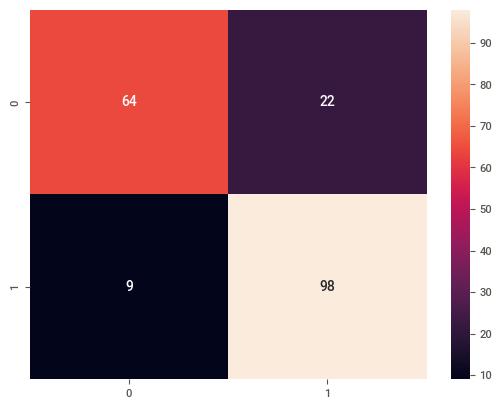


Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.74      0.81        86
           1       0.82      0.92      0.86       107

    accuracy                           0.84       193
   macro avg       0.85      0.83      0.83       193
weighted avg       0.84      0.84      0.84       193



In [37]:
# Print confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred_adjusted)

sns.heatmap(cm, annot=True)

plt.show()

cr = classification_report(y_test, y_pred_adjusted)
print("\nClassification Report:\n", cr)

Through these evaluation metrics, we can assess the model's ability to classify instances accurately and understand its strengths and weaknesses in predicting heart disease. This critical analysis guides us in making any necessary adjustments to improve model performance further.

### Testing on New Data

Having trained and evaluated our model on a training dataset, the next critical step is to test its performance on new, unseen data. This step is essential for understanding how well our model generalizes to data it has not encountered before. We follow the same data preprocessing steps for the new dataset as we did for the training dataset. Finally, we use our trained model to make predictions on this new data and prepare a submission file with these predictions.

#### Preparing the Test Data

The new data must be preprocessed to match the format expected by the model. This involves filtering out missing or implausible values, creating interaction terms, encoding categorical variables, adding polynomial features, and scaling the features, just as we did with the training data.


In [38]:
# Import the test dataset
test = pd.read_csv('test_heart.csv', sep=',')

# Apply the same preprocessing steps to the test data
# Filter out missing or implausible values for Cholesterol and RestingBP
chol_median = test.loc[test['Cholesterol'] != 0, 'Cholesterol'].median()
test['Cholesterol'].replace(0, chol_median, inplace=True)

resting_median = test.loc[test['RestingBP'] != 0, 'RestingBP'].median()
test['RestingBP'].replace(0, resting_median, inplace=True)

# Create interaction term
test['Age_Chol_Interact'] = test['Age'] * test['Cholesterol']

# Prepare the test data
X_new = test.drop(['id'], axis=1)

# Encode and transform the test data using the same encoder and transformers
X_new_encoded = encoder.transform(X_new)
X_new_poly = poly.transform(X_new_encoded)
X_new_scaled = scaler.transform(X_new_poly)

# Predict with each model
y_new_pred_ada = ada_boost_clf.predict(X_new_scaled)
y_new_pred_rf = rf_clf.predict(X_new_scaled)
y_new_pred_log_reg = log_reg.predict(X_new_scaled)

#### Making Predictions and Adjusting Threshold

With the test data prepared, we predict the likelihood of heart disease. We then apply a chosen threshold to these predictions to classify each instance as either having heart disease or not. This threshold is adjustable based on the specific requirements of the task or the desired balance between sensitivity and specificity.

In [39]:
# # Predict probabilities for the test data
# y_new_probs = ada_boost_clf.predict_proba(X_new_scaled)[:, 1]

# # Apply the chosen threshold to classify each instance
# chosen_threshold = 0.4  # This threshold can be adjusted
# y_new_pred_adjusted = np.where(y_new_probs > chosen_threshold, 1, 0)

# Combine the predictions
combined_new_predictions = np.array([y_new_pred_ada, y_new_pred_rf, y_new_pred_log_reg])

# Determine the final prediction by majority vote
final_new_predictions = np.apply_along_axis(lambda x: 1 if np.sum(x) > 1 else 0, axis=0, arr=combined_new_predictions)

# CREATE PANDAS DATAFRAME FOR SUBMISSION with combined predictions
final_id_to_prediction_df = pd.DataFrame({
    'id': test['id'],
    'HeartDisease': final_new_predictions
})


# OUTPUT TO CSV
final_file_name = './final_submission.csv'
final_id_to_prediction_df.to_csv(final_file_name, index=False)

print(f"Final combined predictions saved as {final_file_name}")

Final combined predictions saved as ./final_submission.csv


#### Preparing the Submission File

Finally, we prepare a submission file that includes the predictions for the new data. This file typically contains an ID for each instance and the corresponding prediction. This step is especially relevant in competition or operational settings where predictions need to be shared or deployed.

In [ ]:
# Create a DataFrame for submission
id_to_prediction_df = pd.DataFrame({
    'id': test['id'],
    'HeartDisease': y_new_pred_adjusted
})

# Output the submission file
file_name = '/mnt/data/submission_test.csv'
id_to_prediction_df.to_csv(file_name, index=False)

print(f"File saved as {file_name}")

This step concludes our process of developing a model to predict heart disease. By carefully preparing the test data, making informed predictions, and generating a submission file, we have applied our model to new data, showcasing its potential for real-world applications.

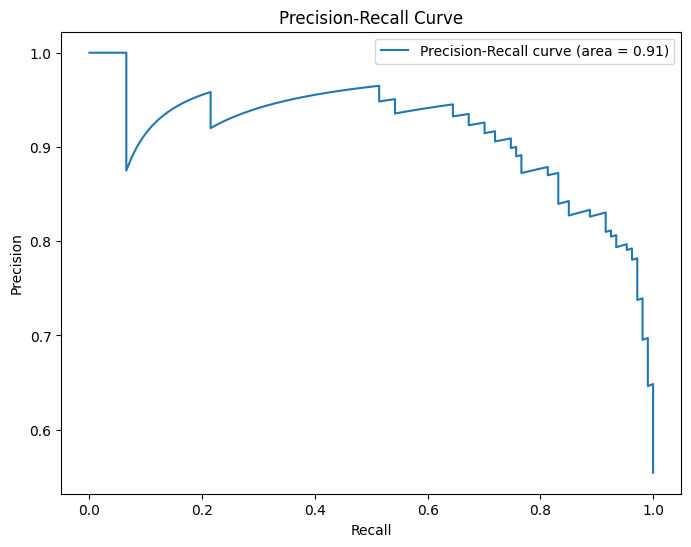

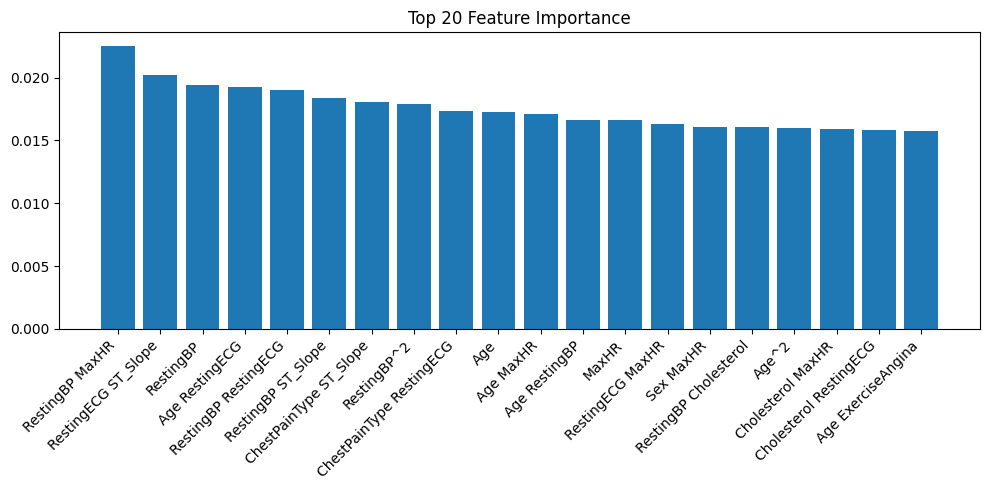

In [23]:
from sklearn.metrics import (classification_report, confusion_matrix, f1_score,
                             precision_score, recall_score, accuracy_score,
                             roc_auc_score, roc_curve)
from sklearn.metrics import precision_recall_curve, auc


def plot_precision_recall_curve(y_true, y_scores):
    """
    Plot Precision-Recall curve for the model.
    
    Parameters:
    - y_true: Actual target values.
    - y_scores: Target scores, can either be probability estimates of the positive class.
    """
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    auc_score = auc(recall, precision)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Precision-Recall curve (area = {auc_score:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()


plot_precision_recall_curve(y_test, y_probs)


def performance_metrics(y_true, y_pred):
    """Calculate and print model performance metrics."""
    # Calculate metrics
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    
    # Print metrics
    print(f'F1-Score: {f1:.5f}\nPrecision: {precision:.5f}\nRecall: {recall:.5f}\nAccuracy: {accuracy:.5f}')


def roc_curve_plot(y_true, y_probs):
    """Plot ROC curve based on true labels and predicted probabilities."""
    roc_auc = roc_auc_score(y_true, y_probs)
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.title('ROC Curve')
    plt.savefig('roc_curve.png')
    plt.show()

def confusion_matrix_heatmap(y_true, y_pred):
    """Generate and display a confusion matrix heatmap."""
    conf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig('confusion_matrix_heatmap.png')
    plt.show()


def plot_feature_importance(model, feature_names, top_n_features=20):
    """
    Plot the importance of features in the model.
    
    Parameters:
    - model: The trained model.
    - feature_names: List of names corresponding to the features used by the model.
    """
    # Extract feature importance from the model
    importances = model.feature_importances_
    
    # Sort feature importances in descending order and select the top N
    indices = np.argsort(importances)[::-1][:top_n_features]
    
    # Rearrange feature names so they match the sorted feature importances
    names = [feature_names[i] for i in indices]
    sorted_importances = importances[indices]
    
    # Create plot
    plt.figure(figsize=(10, 5))
    plt.title("Top {} Feature Importance".format(top_n_features))
    plt.bar(range(top_n_features), sorted_importances, align='center')
    
    # Add feature names as x-axis labels
    plt.xticks(range(top_n_features), names, rotation=45, ha='right')
    
    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
    plt.show()


plot_feature_importance(ada_boost_clf, poly_feature_names)



In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
import category_encoders as ce
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.compose import ColumnTransformer


# IMPORT CSV
hearts = pd.read_csv('train_heart.csv', sep=',')

# FILTER VALUES FOR CHOLESTEROL AND RESTINGBP
chol_median = hearts.loc[hearts['Cholesterol'] != 0, 'Cholesterol'].median()
hearts['Cholesterol'].replace(0, chol_median, inplace=True)
resting_median = hearts.loc[hearts['RestingBP'] != 0, 'RestingBP'].median()
hearts['RestingBP'].replace(0, resting_median, inplace=True)

# CREATE INTERACTION TERM
hearts['Age_Chol_Interact'] = hearts['Age'] * hearts['Cholesterol']

# DROP UNNECESSARY COLUMNS AND FIND y
X = hearts.drop(['id', 'HeartDisease'], axis=1)
y = hearts['HeartDisease']

# Define preprocessing for numerical columns
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Age_Chol_Interact']
numerical_transformer = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical columns
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
categorical_transformer = OneHotEncoder()

# Create a column transformer to apply the transformations to the respective column types
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# ENCODE CATEGORICAL VARIABLES
encoder = ce.OrdinalEncoder(cols=X.select_dtypes(include=['object']).columns)
X_encoded = encoder.fit_transform(X)

# ADD POLYNOMIAL FEATURES
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_encoded)

# SCALE FEATURES
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

# DATA SPLITTING
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Define the parameter grid to search
param_grid_extended = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'ccp_alpha': [0.0, 0.001, 0.005, 0.01, 0.05, 0.1],
    'splitter': ['best', 'random'],
    'class_weight': [None, 'balanced']
}

# Updating the GridSearchCV setup
grid_search_extended = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                                    param_grid=param_grid_extended,
                                    cv=5,
                                    scoring='accuracy',
                                    verbose=1,
                                    n_jobs=-1)

# Fit the model with grid search
grid_search_extended.fit(X_train, y_train)

# Now you can access best_params_
base_est = grid_search_extended.best_estimator_  # Use the best estimator directly


# Stacking Ensemble
# Define base models
base_models = [
    ('ada_boost', AdaBoostClassifier(estimator=base_est, n_estimators=100, random_state=42)),
    ('random_forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('logistic_regression', LinearRegression())
]

# Define the meta-model
meta_model = LogisticRegression()

# Define the stacking ensemble
stacking_ensemble = VotingClassifier(estimators=base_models, voting="hard", n_jobs=-1)

# Fit the stacking ensemble model on the training data
stacking_ensemble.fit(X_train, y_train)

# Predict on the test set with the stacking ensemble model
y_pred_stacking = stacking_ensemble.predict(X_test)

# Calculate and print the stacking ensemble model accuracy
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
print(f'Stacking Ensemble Model Accuracy: {accuracy_stacking}')

# TESTING PART
# IMPORT CSV
test = pd.read_csv('test_heart.csv', sep=',')

# FILTER VALUES FOR CHOLESTEROL AND RESTINGBP
chol_median = test.loc[test['Cholesterol'] != 0, 'Cholesterol'].median()
test['Cholesterol'].replace(0, chol_median, inplace=True)

resting_median = test.loc[test['RestingBP'] != 0, 'RestingBP'].median()
test['RestingBP'].replace(0, resting_median, inplace=True)

# CREATE INTERACTION TERM
test['Age_Chol_Interact'] = test['Age'] * test['Cholesterol']

# Prepare the test data following the same steps as for the training data
X_new = test.drop(['id'], axis=1)

# ENCODE X using the same encoder
X_new_encoded = encoder.transform(X_new)

# ADD POLYNOMIAL FEATURES AND SCALE using the same transformers
X_new_poly = poly.transform(X_new_encoded)
X_new_scaled = scaler.transform(X_new_poly)

# Predict with the stacking ensemble model on the processed test data
y_new_pred_stacking = stacking_ensemble.predict(X_new_scaled)

# No need for applying a separate threshold here as we're using direct predictions from the stacking model

# CREATE PANDAS DATAFRAME FOR SUBMISSION with predictions from the stacking ensemble model
id_to_prediction_df = pd.DataFrame({
    'id': test['id'],
    'HeartDisease': y_new_pred_stacking
})

# OUTPUT TO CSV file for submission or further analysis
file_name = './final_submission_stacking.csv'
id_to_prediction_df.to_csv(file_name, index=False)

print(f"File saved as {file_name}")


Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


TypeError: LinearRegression.__init__() got an unexpected keyword argument 'max_iter'